In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Add, Activation, Conv1D, Conv2D, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
import numpy as np

2024-01-17 11:22:22.891360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 11:22:22.891453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 11:22:22.928570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 11:22:23.004069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 11:22:23.862677: W tensorflow/compiler/tf2

In [2]:
dataset_npz = np.load('dataset_bottle.npz')

# estrai immagini ed etichette
immagini = dataset_npz['immagini']
etichette = dataset_npz['etichette']

In [3]:
# creadataset 

dataset = tf.data.Dataset.from_tensor_slices((immagini, etichette))

2024-01-17 11:22:25.660890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 11:22:25.891159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 11:22:25.891500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
images_train, images_test, label_train, label_test = train_test_split(immagini, etichette, test_size=0.2, random_state=42)

In [5]:
print(images_train.shape)

(363, 28, 28, 3)


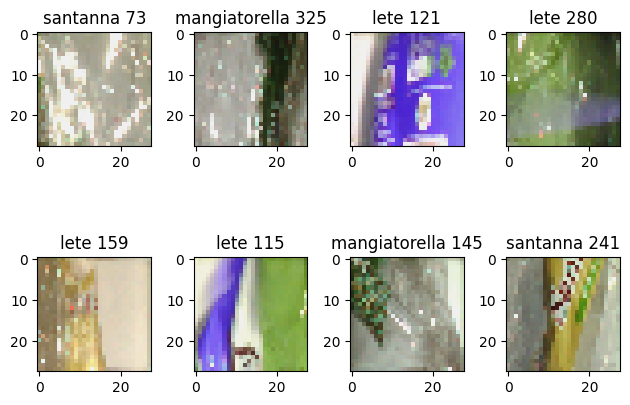

In [6]:
# stampa le prime 10 immagini
import random


width = images_train.shape[1] # 28
height = images_train.shape[2] # 28
rows = 2
cols = 4
axes = []
fig = plt.figure()

for a in range(rows * cols):
    n = random.randrange(images_train.shape[0])
    b = images_train[n]
    e = etichette[n]
    axes.append(fig.add_subplot(rows, cols, a + 1))
    subplot_title = f"{e} {str(n)}"
    axes[-1].set_title(subplot_title)
    plt.imshow(b)
fig.tight_layout()
plt.show()

In [7]:
# convert the RGB images into a grayscale
def rgb_to_grayscale(rgb_images):
    return np.mean(rgb_images, axis=-1)

In [8]:
images_train_grayscale = rgb_to_grayscale(images_train)
images_test_grayscale = rgb_to_grayscale(images_test)

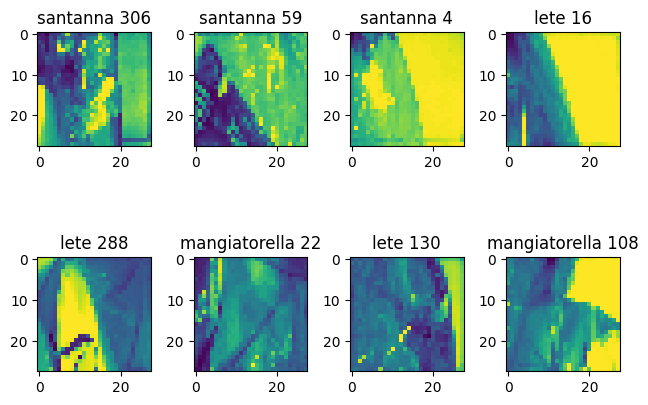

In [9]:
# stampa le prime 10 immagini
import random


width = images_train_grayscale.shape[1] # 28
height = images_train_grayscale.shape[2] # 28
rows = 2
cols = 4
axes = []
fig = plt.figure()

for a in range(rows * cols):
    n = random.randrange(images_train_grayscale.shape[0])
    b = images_train_grayscale[n]
    e = etichette[n]
    axes.append(fig.add_subplot(rows, cols, a + 1))
    subplot_title = f"{e} {str(n)}"
    axes[-1].set_title(subplot_title)
    plt.imshow(b)
fig.tight_layout()
plt.show()

In [10]:
#### Inizio lavoro sulla rete neurale --- Data Preprossing

print(images_train_grayscale.shape)

images_train_grayscale = images_train_grayscale.reshape((images_train_grayscale.shape[0],28,28,1)).astype('float32')
images_test_grayscale = images_test_grayscale.reshape((images_test_grayscale.shape[0],28,28,1)).astype('float32')

print(images_train_grayscale.shape)
print(images_test_grayscale.shape)


(363, 28, 28)
(363, 28, 28, 1)
(91, 28, 28, 1)


In [11]:
# normalizzo
images_train_grayscale = images_train_grayscale/255
images_test_grayscale = images_test_grayscale/255 

In [12]:
new_label_train = []
new_label_test = []

for label in label_train:
    match label:
            case "lete":
                new_label_train.append(1)
            case "mangiatorella":
                new_label_train.append(2)
            case "santanna":
                new_label_train.append(3)
            case _:
                new_label_train.append(0)
                
for label in label_test:
    match label:
            case "lete":
                new_label_test.append(1)
            case "mangiatorella":
                new_label_test.append(2)
            case "santanna":
                new_label_test.append(3)
            case _:
                new_label_test.append(0)

# print(new_label_train)
# print(new_label_test)

new_label_train = to_categorical(new_label_train)
new_label_test = to_categorical(new_label_test)

new_label_train[0]

array([0., 0., 0., 1.], dtype=float32)

In [13]:
print(new_label_train.shape)
print(new_label_test.shape)

(363, 4)
(91, 4)


In [14]:
from tensorflow.keras.layers import Dense, Input, Add, Activation, Conv1D, Conv2D, Flatten, Conv3D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import Adam

In [15]:
shape_value = images_train_grayscale.shape[0] # 28x28 -> 784
print(shape_value)

input = Input(shape=(28,28,1)) # posso creare anche custom objects che userò successivamente senza ripetere tutto.

conv_0 = Conv2D(
        32, 
        kernel_size=(3,3), 
        activation='relu',
    )(input)

max_pooling_0 = MaxPooling2D((2,2))(conv_0)

conv_1 = Conv2D(
        64, 
        kernel_size=(3,3), 
        activation='relu'
    )(max_pooling_0)


max_pooling_1 = MaxPooling2D((2,2))(conv_1)

conv_2 = Conv2D(
        64, 
        kernel_size=(3,3), 
        activation='relu'
    )(max_pooling_1)

# dense_0 = Dense(units=64, activation='relu')(conv_0)

# residual_0 = Add()([conv_1, conv_2])
# residual_0 = Activation('swish')(residual_0) # torna indietro con la derivata prima parziale della funzione relu


# flatten_0 = Flatten()(residual_0)
flatten_0 = Flatten()(conv_2)

dense_0 = Dense(
    64,
    activation='relu'
)(flatten_0)

output = Dense(
        units=4, 
        activation='softmax' # Softmax makes the output sum up to 1 so the output can be interpreted as probabilities.
    )(dense_0)


model = tf.keras.models.Model(
    inputs=[input],
    outputs=[output],
    name="Conv-Bottle"
)

model.summary()


363
Model: "Conv-Bottle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)      

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
history_res = model.fit(
    x=images_train_grayscale,
    y=new_label_train,
    epochs=8,
    batch_size=64,
    validation_data=(
        images_test_grayscale,
        new_label_test
    )
)

Epoch 1/8


2024-01-17 11:22:27.837431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


6/6 [==============================] - 2s 118ms/step - loss: 1.2355 - accuracy: 0.2562 - val_loss: 1.2678 - val_accuracy: 0.3297
Epoch 2/8
6/6 [==============================] - 0s 7ms/step - loss: 1.1936 - accuracy: 0.2755 - val_loss: 1.1774 - val_accuracy: 0.3516
Epoch 3/8
6/6 [==============================] - 0s 5ms/step - loss: 1.1547 - accuracy: 0.3416 - val_loss: 1.1337 - val_accuracy: 0.3516
Epoch 4/8
6/6 [==============================] - 0s 6ms/step - loss: 1.1330 - accuracy: 0.2948 - val_loss: 1.1020 - val_accuracy: 0.3297
Epoch 5/8
6/6 [==============================] - 0s 5ms/step - loss: 1.1045 - accuracy: 0.3278 - val_loss: 1.1028 - val_accuracy: 0.3187
Epoch 6/8
6/6 [==============================] - 0s 5ms/step - loss: 1.1027 - accuracy: 0.3416 - val_loss: 1.1002 - val_accuracy: 0.3297
Epoch 7/8
6/6 [==============================] - 0s 5ms/step - loss: 1.1065 - accuracy: 0.3251 - val_loss: 1.1015 - val_accuracy: 0.3516
Epoch 8/8
6/6 [==============================] - 

In [18]:
# save the model
model.save('bottle_model.h5')

/home/ezanardo/Github/m3-gpu-ml/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


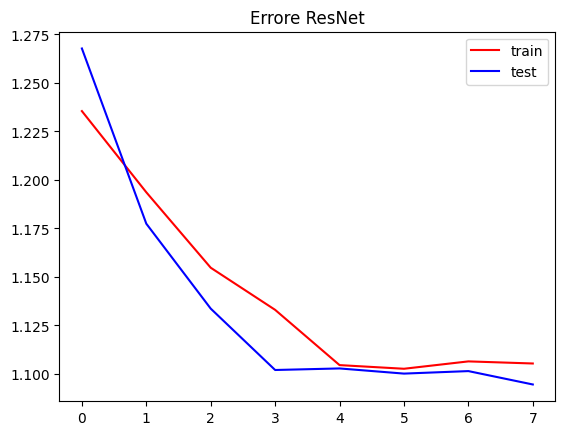

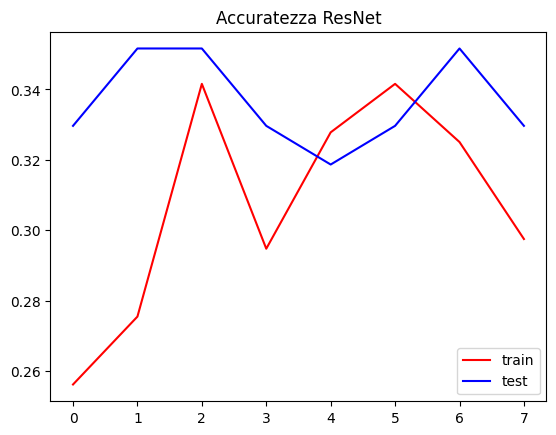

In [19]:
# Stampe i risultati

# errore modello
plt.plot(history_res.history['loss'], color='red', label='train')
plt.plot(history_res.history['val_loss'], color='blue', label='test')
plt.title('Errore BottleNet' )
plt.legend()
plt.show()

# Accuratezza del modello
plt.plot(history_res.history['accuracy'], color='red', label='train')
plt.plot(history_res.history['val_accuracy'], color='blue', label='test')
plt.title("Accuratezza BottleNet")
plt.legend()
plt.show()

In [20]:
evaluations_res = model.evaluate(
    images_test_grayscale,
    new_label_test
)

for i in range(0, len(model.metrics_names)):
    print(f"{model.metrics_names[i]} -> {evaluations_res[i]}")

3/3 [==============================] - 0s 2ms/step - loss: 1.0946 - accuracy: 0.3297
loss -> 1.094563603401184
accuracy -> 0.32967033982276917


In [21]:
# evaluate sending a "real" image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [22]:
# load the saved model
saved_model = load_model('bottle_model.h5')

In [28]:
# Load the personal image for evaluation
img_path = './img/santanna_13.png'
# img_path = './img/mangiatorella_22.png'
# img_path = './img/lete_100.png'


img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255





In [27]:
predictions = saved_model.predict(img_array)
prediceted_label = np.argmax(predictions)

'''
lete-> 1
mangiatorella -> 2
santanna -> 3
other -> 0
'''

match prediceted_label:
            case 1:
                print(f"Predicted label: 'lete'")
            case 2:
                 print(f"Predicted label: 'mangiatorella'")
            case 3:
                print(f"Predicted label: 'santanna'")
            case _:
                 print(f"Predicted label: 'other'")





1/1 [==============================] - 0s 13ms/step
Predicted label: 'santanna'
